.\\data2\\Arms_resized\\
Full dataset tensor: (784, 20, 20)
Mean: 0.112733
Standard deviation: 0.132943
.\\data2\\Figure_normal_legs_resized\\
Full dataset tensor: (622, 20, 20)
Mean: 0.0883928
Standard deviation: 0.15396
.\\data2\\FigureWheels_resized\\
Full dataset tensor: (222, 20, 20)
Mean: 0.0750712
Standard deviation: 0.153478
.\\data2\\Head_resized\\
Full dataset tensor: (473, 20, 20)
Mean: 0.0370673
Standard deviation: 0.192848
Total samples number: (2101, 20, 20)
Samples for tests: 526
Samples for trains: 1575


Using TensorFlow backend.


(20, 20)
4
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 400)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 400)               160400    
_________________________________________________________________
dropout_1 (Dropout)          (None, 400)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 200)               80200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
output (Dense)               (None, 4)                 804       
_________________________________________________________________
softmax (Activation)         (None, 4)                 0         

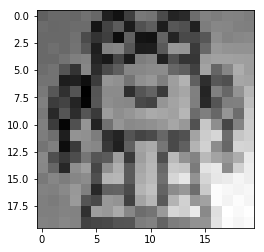

In [2]:
# TASK: LOAD IMAGES FROM DATASET INTO ACTUAL CONTAINERS FOR LATER FITTING
# testing the image collection
# with new resized images
# minimum number of images = 100

from __future__ import print_function
import matplotlib.pyplot as plt
import PIL
from PIL import Image
import numpy as np
import os
import shutil
import sys
from scipy import ndimage
from sklearn.model_selection import train_test_split

% matplotlib inline

image_size = 20  # Pixel width and height
pixel_depth = 255.0  # Number of levels per pixel

folders_resized = [
    r'.\\data2\\Arms_resized\\',
    r'.\\data2\\Figure_normal_legs_resized\\',
    r'.\\data2\\FigureWheels_resized\\',
    r'.\\data2\\Head_resized\\'
]

# loading the data for a single image label
def load_parts(folder, min_num_images):
    image_files = os.listdir(folder)
    dataset = np.ndarray(shape=(len(image_files), image_size, image_size), dtype=np.float32)
    print(folder)
    num_images = 0
    
    for image in image_files:
        image_file = os.path.join(folder, image)
        
        try:
            image_data = (ndimage.imread(image_file).astype(float) - pixel_depth / 2) / pixel_depth
            if image_data.shape != (image_size, image_size):
                raise Exception('Unexpected image shape: %s' % str(image_data.shape))
            dataset[num_images, :, :] = image_data
            num_images = num_images + 1
        except IOError as e:
            print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')

    dataset = dataset[0:num_images, :, :]
    if num_images < min_num_images:
        raise Exception('Many fewer images than expected: %d < %d' % (num_images, min_num_images))

    print('Full dataset tensor:', dataset.shape)
    print('Mean:', np.mean(dataset))
    print('Standard deviation:', np.std(dataset))
    
    return dataset

X_datasets = list()
Y_datasets = list()

for idx in range(len(folders_resized)):
    folder = folders_resized[idx] 
    X_datasets.append(load_parts(folder, 100))
    labels = np.zeros((X_datasets[-1].shape[0],len(folders_resized)))
    labels[:,idx] = 1
    Y_datasets.append(labels)

X_datasets2 = np.concatenate(X_datasets)
Y_datasets2 = np.concatenate(Y_datasets)
print("Total samples number:", X_datasets2.shape)

X_trains,X_tests,Y_trains,Y_tests = train_test_split(X_datasets2,Y_datasets2,test_size=0.25)
print("Samples for tests:", Y_tests.shape[0])
print("Samples for trains:", Y_trains.shape[0])

plt.imshow(X_tests[0],cmap='gray')



# TASK: BUILD THE MODEL NETWORKS, COMPILE & FIT IT, WRITE DOWN THE ACCURACY/ERROR OF THE MODEL
# create the model networks with Keras
from keras.models import Sequential
from keras.layers import Dense,Dropout,Activation,Reshape,LSTM
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.optimizers import SGD
import numpy

# callbacks are a set of rules that will stop the model fitting from being too long or infinite
callbacks = [
    EarlyStopping(monitor='val_loss', min_delta=0.00001, verbose=1),
    ModelCheckpoint(filepath='./weights_test.net', verbose=1, save_best_only=True),
]

# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

input_dim = X_trains[0].shape[0]*X_trains[0].shape[1]
print((X_trains[0].shape[0], X_trains[0].shape[1]))
print(Y_trains[0].shape[0])

# create model
model = Sequential()

model.add(Reshape((input_dim,), input_shape=(X_trains[0].shape[0],X_trains[0].shape[1])))
model.add(Dense(input_dim, input_shape = (input_dim,), kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(0.01))
model.add(Dense(int(input_dim/2), kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(0.01))
model.add(Dense(Y_trains[0].shape[0], kernel_initializer = 'uniform', name = "output"))

model.add(Activation('softmax', name = "softmax"))
model.summary()

# Compile model
sto_grad_descent = SGD(lr = 0.2, decay = 0.000001, momentum = 0.9, nesterov = True) #1e-6
model.compile(loss = 'binary_crossentropy', optimizer = sto_grad_descent, metrics = ['accuracy'])

# Fit the model
model.fit(X_trains, Y_trains, epochs = 10, batch_size = 10, verbose = 2, validation_split = 0.25, callbacks = callbacks)

# calculate predictions
results = model.evaluate(X_tests, Y_tests, batch_size = 32, verbose = 1, sample_weight = None)

# round predictions
print(results)